In [4]:
%load_ext autoreload
%autoreload 2


import os,sys
#sys.path.append(os.path.join(os.path.dirname("src_py/models/pivae.py"), '../'))
#print(sys.path)
sys.path.append("../src_py")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from tqdm import tqdm, trange
import cmdstanpy
import pandas as pd
from models.phi import PHI
from models.vae import VAE
import torch
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

In [5]:
# cmdstanpy.install_cmdstan()

In [6]:
plt.style.use('seaborn-paper')
mpl.rc('axes.spines', right=False, top=False)
mpl.rc('axes', labelsize=20)
mpl.rc('xtick', labelsize=16, top=False)
mpl.rc('xtick.minor', visible=False)
mpl.rc('ytick', labelsize=16, right=False)
mpl.rc('ytick.minor', visible=False)
mpl.rc('savefig', bbox='tight', format='pdf')
mpl.rc('figure', figsize=(10, 10))
mpl.rc('legend',fontsize=16)

/var/folders/4t/jg_lw7tj1dbdyv9kjdpny9_r0000gn/T/ipykernel_34135/1449278656.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [7]:
# creating phi model
phi = PHI(1, alpha=1.0, n_centers=1000, hidden_dim1=20, hidden_dim2=20, out_dims=10)
import pickle
with open('2dgp_phi.pkl', 'rb') as f:
    weights_phi = pickle.load(f)
print(weights_phi.keys())
phi.state_dict().keys()
phi.load_state_dict(weights_phi)
phi.eval()

here2
odict_keys(['centers', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'out.weight', 'out.bias'])


RuntimeError: Error(s) in loading state_dict for PHI:
	size mismatch for centers: copying a param with shape torch.Size([1000, 2]) from checkpoint, the shape in current model is torch.Size([1000, 1]).
	size mismatch for linear1.weight: copying a param with shape torch.Size([100, 1000]) from checkpoint, the shape in current model is torch.Size([20, 1000]).
	size mismatch for linear1.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for linear2.weight: copying a param with shape torch.Size([100, 100]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for linear2.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for out.weight: copying a param with shape torch.Size([50, 100]) from checkpoint, the shape in current model is torch.Size([10, 20]).
	size mismatch for out.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([10]).

In [11]:
# creating vae model
vae = VAE(input_dim=10, hidden_dim1=16, hidden_dim2=8, latent_dim=5)
import pickle
with open('monotonic_vae.pkl', 'rb') as f:
    weights_vae = pickle.load(f)
vae.decoder.load_state_dict(weights_vae)
vae.decoder.eval()

Decoder(
  (linear1): Linear(in_features=5, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=10, bias=True)
)

Text(0, 0.5, '$y=f(x)$')

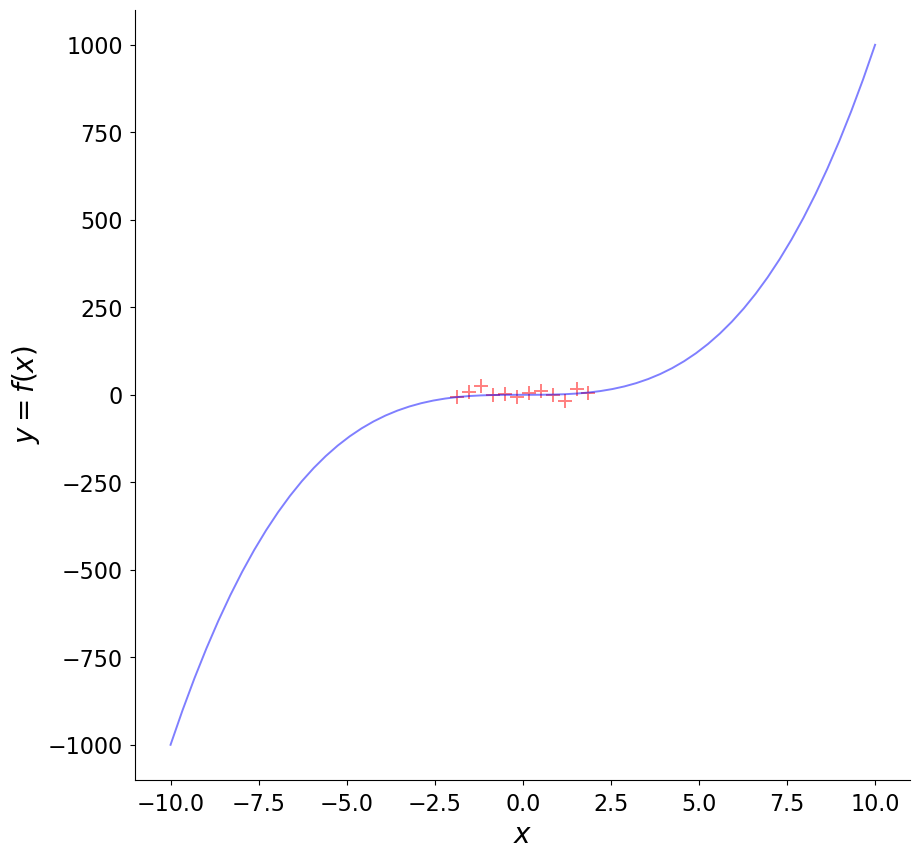

In [12]:
# sampling points to evaluate functions values
x_inf = np.linspace(-10,10,60).reshape(-1,1)
e_n = 9 * np.random.randn(60).reshape(-1,1)
y_ = np.power(x_inf,3) 
y_inf = np.power(x_inf,3) + e_n
idx = (x_inf>=-2) * (x_inf<=2)
ll_idx = np.where(idx)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_inf, y_, color='blue', alpha=0.5)
ax.scatter(x_inf[ll_idx], y_inf[ll_idx], marker='+', color='red', alpha=0.5, s=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')

In [13]:
stan_data = {'p': 5, 
                 'p1': 16,
                 'p2': 8,
                 'n': 60,
                 'W1': weights_vae['linear1.weight'].T.numpy(),
                 'B1': weights_vae['linear1.bias'].T.numpy(),
                 'W2': weights_vae['linear2.weight'].T.numpy(),
                 'B2': weights_vae['linear2.bias'].T.numpy(),
                 'W3': weights_vae['out.weight'].T.numpy(),
                 'B3': weights_vae['out.bias'].T.numpy(),
                 'beta_dim' : 10,
                 'phi_x' : phi(torch.tensor(x_inf).float()).detach().numpy(),
                 'y': y_inf.reshape(60,),
                 'll_len' : ll_idx[0].shape[0],
                 'll_idxs' : ll_idx[0]}

/var/folders/4t/jg_lw7tj1dbdyv9kjdpny9_r0000gn/T/ipykernel_33917/1663395612.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1660136240338/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  'B1': weights_vae['linear1.bias'].T.numpy(),


In [14]:
sm = cmdstanpy.CmdStanModel(stan_file='pivae.stan')

09:23:27 - cmdstanpy - INFO - compiling stan file /Users/seth/Dropbox/Seth/Research/pi-vae/emailed/pivae.stan to exe file /Users/seth/Dropbox/Seth/Research/pi-vae/emailed/pivae
09:23:39 - cmdstanpy - INFO - compiled model executable: /Users/seth/Dropbox/Seth/Research/pi-vae/emailed/pivae
09:23:39 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
09:23:39 - cmdstanpy - WARNING - arm64-apple-darwin20.0.0-clang++ -ftree-vectorize -fPIC -fPIE -fstack-protector-strong -O2 -pipe -stdlib=libc++ -fvisibility-inlines-hidden -fmessage-length=0 -isystem /Users/seth/mambaforge/envs/pi-vae/include -std=c++1y -Wno-unknown-warning-option -Wno-tautological-compare -Wno-sign-compare -D_REENTRANT -Wno-ignored-attributes      -I /Users/seth/mambaforge/envs/pi-vae/include/    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I s

In [13]:
fit = sm.sample(data=stan_data, iter_sampling=2000, iter_warmup=500, chains=4)

19:16:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:12 - cmdstanpy - INFO - CmdStan done processing.


In [14]:
out = fit.stan_variables()

df = pd.DataFrame(out['y2'])

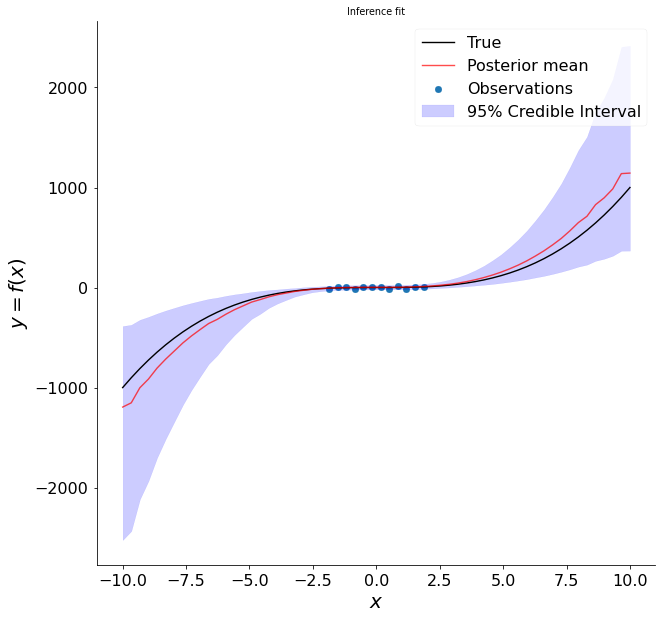

In [15]:
datapoints = x_inf
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(datapoints, y_, color='black', label='True')
ax.scatter(datapoints[ll_idx], y_inf[ll_idx], s=46,label = 'Observations')
ax.fill_between(datapoints.reshape(datapoints.shape[0]), df.quantile(0.025).to_numpy(), df.quantile(0.975).to_numpy(),
                    facecolor="blue",
                    color='blue', 
                    alpha=0.2, label = '95% Credible Interval') 
ax.plot(datapoints, df.mean().to_numpy().reshape(-1,1), color='red', alpha=0.7, label = 'Posterior mean')
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Inference fit')
ax.legend()